# My-Fashion-MNIST-Experiments

In this notebook, I will design my own CNN architecture for classifying the Fashion-MNIST dataset, and will write functions such that I can experiment with different hyperparameters and loss functions/optimizers. LESHGOOOO

Note that just for loading the data in, I will use pre-existing code from [this tutorial](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html), which I also used in my `fashion-mnist.ipynb` notebook.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F 

from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [3]:
train_data = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [12]:
# experiment - play with the number of batches I want
# default is 4
batch_size = 5

In [13]:
# Create data loaders for our datasets; shuffle for training, not for test
training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [14]:
# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(train_data)))
print('Testing set has {} instances'.format(len(test_data)))

Training set has 60000 instances
Testing set has 10000 instances


Dress  T-shirt/top  Pullover  Trouser  Coat


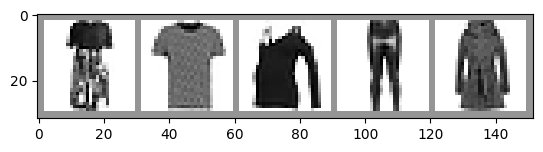

In [18]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(batch_size)))

In [29]:
len(train_data)

60000

In [28]:
train_sample, train_label = train_data[0]
train_sample.shape

torch.Size([1, 28, 28])

## Defining Model Architecture

Let's go for 3 convolutions, 4 fully-connected layers, options for activation (ReLU, sigmoid, tanh), and options for pooling (max, avg). This also gives me a great chance to 1. test out different model architectures, and 2. to test out the limits of my machine (MacBook Pro M3).

In [34]:
def cnn_dims(input_matrix_size, kernel_size):
    output_size_n = input_matrix_size - kernel_size + 1
    print(f'Input matrix size: {input_matrix_size}x{input_matrix_size}')
    print(f'Kernel size: {kernel_size}x{kernel_size}')
    print(f'Therefore output convolved matrix size: {output_size_n}x{output_size_n}')
    return output_size_n

In [39]:
cnn_dims(28, 5)

Input matrix size: 28x28
Kernel size: 5x5
Therefore output convolved matrix size: 24x24


24

In [40]:
my_params = {
    # number of output channels for 1st convolution
    'conv1_out_channels':6,
    # kernel size - same for all convolutions
    'kernel_size':5,
    # stride - same for all convolutions
    'stride':1,
    # number of convolutional layers - max 4
    'n_conv':3,
    # number of fully-connected layers - max 4
    'n_fc':3,
    # desired pooling type - either of {'max', 'avg'}
    'pool_type': 'max',
    # desired activation - either of {'relu', 'sigmoid', 'tanh'}
    'activation_type': 'relu'
}

In [41]:
my_params['n_fc']

3

In [42]:
class MyFashionClassifier(nn.Module, my_params):

    def __init__(self):
        super(MyFashionClassifier, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=my_params['conv1_out_channels'],
            kernel_size=my_params['kernel_size'],
            stride=my_params['stride']
        )
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=5,
            stride=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=20,
            kernel_size=5,
            stride=1
        )
        # self.conv4 = nn.Conv2d(
        #     in_channels=20,
        #     out_channels=25,
        #     kernel_size=5,
        #     stride=1
        # )
        self.maxpool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        self.avgpool = nn.AvgPool2d(
            kernel_size=2,
            stride=2
        )
        self.fc1 = nn.Linear(
            in_features=25*4*4,
            out_features=120
        )
        self.fc2 = nn.Linear(
            in_features=120,
            out_features=80
        )
        self.fc3 = nn.Linear(
            in_features=80,
            out_features=30
        )
        self.fc4 = nn.Linear(
            in_features=30,
            out_features=10
        )

    def forward(self, x, my_params):
        if my_params['pool_type']=='max':
            if my_params['activation_type']=='relu':
                x = self.maxpool(F.relu(self.conv1(x)))
                x = self.maxpool(F.relu(self.conv2(x)))
                x = self.maxpool(F.relu(self.conv3(x)))
                x = x.view(-1, 16 * 4 * 4)
                x = F.relu(self.fc1(x))
                x = F.relu(self.fc2(x))
                x = F.relu(self.fc3(x))
                x = self.fc4(x)
        return x

TypeError: metaclass conflict: the metaclass of a derived class must be a (non-strict) subclass of the metaclasses of all its bases